In [11]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

[]


In [12]:
import json
import time
import pandas as pd
from collections import Counter
import torch

import pandas as pd
import numpy as np
import nltk
import string
import re
import emoji
import torch
import json
import time

from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [13]:
# Basic data files and paths
TOP_100_PATH = '../data/popular_100_memes.csv'
TOP_100 = pd.read_csv(TOP_100_PATH, encoding = "ISO-8859-1")
DATA_PATH = '../data/memes/'

STATS_PATH = '../data/statistics.json'
with open(STATS_PATH, 'r') as f:
    STATS = json.load(f)
print(TOP_100.head())

          ID                   Name  \
0  112126428   Distracted Boyfriend   
1     438680  Batman Slapping Robin   
2   87743020            Two Buttons   
3  181913649    Drake Hotline Bling   
4      61579    One Does Not Simply   

                                     Alternate Names  
0  distracted bf, guy checking out another girl, ...  
1                                                NaN  
2  2 red buttons, choice button, which button, da...  
3  drakeposting, drakepost, drake hotline approve...  
4  one does not simply walk into morder, lord of ...  


In [14]:
memes_count = Counter(STATS['memes'])
print(len(STATS['memes']))
for f, c in memes_count.most_common():
    print(f, c)

99
Bad-Luck-Brian.json 32141
One-Does-Not-Simply.json 26186
Philosoraptor.json 19971
Boardroom-Meeting-Suggestion.json 18164
Futurama-Fry.json 17325
First-World-Problems.json 17272
The-Most-Interesting-Man-In-The-World.json 15850
Batman-Slapping-Robin.json 14802
Bad-Pun-Dog.json 13194
X-X-Everywhere.json 12985
Expanding-Brain.json 12826
Two-Buttons.json 12232
But-Thats-None-Of-My-Business.json 11097
Ancient-Aliens.json 10555
Creepy-Condescending-Wonka.json 10374
Grumpy-Cat.json 9569
Y-U-No.json 9370
The-Rock-Driving.json 9286
That-Would-Be-Great.json 8600
Waiting-Skeleton.json 8592
Change-My-Mind.json 8563
Leonardo-Dicaprio-Cheers.json 8377
10-Guy.json 8258
Captain-Picard-Facepalm.json 8105
Matrix-Morpheus.json 7833
Third-World-Skeptical-Kid.json 7782
Confession-Bear.json 7778
Am-I-The-Only-One-Around-Here.json 7291
Success-Kid.json 7074
Hide-the-Pain-Harold.json 6973
Roll-Safe-Think-About-It.json 6948
Evil-Toddler.json 6106
Awkward-Moment-Sealion.json 6101
Face-You-Make-Robert-Downey-

In [15]:
selected_memes = [
    'Woman-Yelling-At-Cat.json',
    'Left-Exit-12-Off-Ramp.json',
    'Surprised-Pikachu.json',
    'Is-This-A-Pigeon.json',
    'Drake-Hotline-Bling.json'
]

def open_data(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

memes_data = [open_data(DATA_PATH + meme) for meme in selected_memes]

In [16]:
memes_data

[[{'url': 'https://i.imgflip.com/3z10rd.jpg',
   'post': 'https://imgflip.com/i/3z10rd',
   'metadata': {'views': '366',
    'img-votes': '1',
    'title': 'What are you doing me?',
    'author': 'mjelliott80'},
   'boxes': ["me: i don't know what to do with my life",
    "me to me: and i don't want to see it"]},
  {'url': 'https://i.imgflip.com/3zasdf.jpg',
   'post': 'https://imgflip.com/i/3zasdf',
   'metadata': {'views': '123',
    'img-votes': 0,
    'title': 'Woman Yelling At Cat',
    'author': 'NashVillainyNashVillainy'},
   'boxes': ['you said you were a black person', 'i lied']},
  {'url': 'https://i.imgflip.com/3y8lzm.jpg',
   'post': 'https://imgflip.com/i/3y8lzm',
   'metadata': {'views': '1,659',
    'img-votes': '8',
    'title': 'ur mum',
    'author': 'Questionable_Memes'},
   'boxes': ['You',
    'When your mom yells at you for buying robux with her credit card']},
  {'url': 'https://i.imgflip.com/3yzqug.jpg',
   'post': 'https://imgflip.com/i/3yzqug',
   'metadata': 

In [17]:
# Preprocessing data for modelling
from nltk import sent_tokenize, word_tokenize
from gensim.models import Word2Vec

In [18]:
def parse_text(text):
    text = text.lower().strip()
    return word_tokenize(text)

def parse_blocks(blocks):
    result = []
    for i,b in enumerate(blocks):
        result.append(parse_text(b))
#         if i < len(blocks) - 1:
#             result.extend('|')
    return result

ex = parse_blocks(memes_data[0][0]['boxes'])
print(ex)
model = Word2Vec(ex, min_count=1)
print(model)

[['me', ':', 'i', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'my', 'life'], ['me', 'to', 'me', ':', 'and', 'i', 'do', "n't", 'want', 'to', 'see', 'it']]
Word2Vec(vocab=15, size=100, alpha=0.025)


In [19]:
lines = []
for i in ex:
    lines.append(i)
print(lines)

[['me', ':', 'i', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'my', 'life'], ['me', 'to', 'me', ':', 'and', 'i', 'do', "n't", 'want', 'to', 'see', 'it']]


# Classifier

In [22]:
# making X and y for RNN
word = []
y = []
for i in range(len(memes_data)-1):
    print("This is i: " + str(i))
    for ele in memes_data[i]:
        
        #create word array = x
        #print("This is ele: " + str(ele))
        box = ele['boxes']
        #for now only take first element of parsedtext
        parsedtext = parse_blocks(box)[0]
        #print("This is parsedtext: " + str(parsedtext)) 
        word.append(parsedtext)
        
        #create y array 
        title = ele['metadata']['title']
        #print("This is title: " + str(title))
        
        if  title == 'Woman Yelling At Cat':
            y.append(0)
        elif title == 'Left Exit 12 Off Ramp':
            y.append(1)

        elif title == 'Surprised Pikachu':
            y.append(2)
        elif title == 'Is This A Pigeon': 
            y.append(3)
        else:          #Drake-Hotline-Bling
            y.append(4)   
print(word)
print(y)       
        #attempt to take all elements of parsedtext
        #textinameme = []
        #each meme has multiple arrays of sentences in box
        #make an array with all of the words in box 
        #for textele in  parsedtext:
        #    print("This is textele: " + str(textele))
        #    textinameme.append(textele)
            
        #print("This is textinameme: " + str(textinameme)) 

This is i: 0
This is i: 1
This is i: 2
This is i: 3
[['me', ':', 'i', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'my', 'life'], ['you', 'said', 'you', 'were', 'a', 'black', 'person'], ['you'], ['study', 'for', 'test'], ['people', 'yelling', 'at', 'china', 'for', 'spreading', 'corona'], ['me', 'thinking', 'a', 'demon', "'s", 'in', 'my', 'room', '.', 'pile', 'of', 'clothes', 'on', 'my', 'dresser', '.'], ['the', 'earth', 'is', 'flat'], ['my', 'friend', 'shipping', 'me', 'and', 'some', 'other', 'dude'], ['how', 'dare', 'you', 'cheat', 'on', 'me', '!', '!', 'dude', 'im', 'your', 'cat'], ['we', 'are', 'not', 'naming', 'her', 'ripley'], ['you', 'had', 'no', 'glove', 'on', 'your', 'hand'], ['me', 'telling', 'my', 'teachers', 'they', 'send', 'alot', 'of', 'homework'], ['i', 'hates', 'meeces', 'to', 'pieces', '!', '!', '!', '!', 'next', 'time', ',', 'get', 'them', 'grilled', 'with', 'a', 'side', 'of', 'truffle', 'butter', '...'], ['you', 'said', 'i', 'was', 'your', 'life', '!', 'i', 'have'

In [23]:
X_words = word

In [25]:
len(y)
#len(word)

15677

In [26]:
yset = set(y)
yset

{0, 1, 2, 3, 4}

In [27]:
word[0]

['me', ':', 'i', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'my', 'life']

In [28]:
# making word embeddings for RNN
UNK = "<unk>"
WORDEMBSIZE = 64
W2V_WINDOW = 7
W2V_COUNT = 1
W2V_EPOCH=100

def makeVocab(text):
    vocab = set()
    for sentences in text:
        for word in sentences:
            vocab.add(word)
    return vocab

def makeEmbModel(data):
    docs = [[UNK]]
    docs.extend(data)
    model = Word2Vec(window=W2V_WINDOW, min_count=W2V_COUNT, size=WORDEMBSIZE)
    model.build_vocab(docs)
    model.train(docs, total_examples=len(docs), epochs=W2V_EPOCH)
    print(model)
    return model

def makeEmbeddings(data, model, vocab):
    vecData = []
    for sentence in data:
        wordEmbs = []
        for word in sentence:
            if word in vocab:
#                 print(type(model[word]))
#                 print(model[word])
                wordEmbs.append(model[word])
            else:
                wordEmbs.append(np.zeros(WORDEMBSIZE))
        wordEmbs = torch.FloatTensor(wordEmbs)
        vecData.append(wordEmbs)
    return vecData

In [29]:
# continue making word embeddings
X_words_train, X_words_test, y_train, y_test = train_test_split(X_words, y, test_size=0.2, random_state=42)
vocab = makeVocab(X_words_train)
emb_model = makeEmbModel(X_words_train)
vocab = set(list(emb_model.wv.vocab.keys()))
X_train = makeEmbeddings(X_words_train, emb_model, vocab)
X_test = makeEmbeddings(X_words_test, emb_model, vocab)

print(X_words_train[0])
print(X_train[0])
print(y_train[0])

Word2Vec(vocab=10737, size=64, alpha=0.025)


/Users/kathy908000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['some', 'women', 'yelling', 'at', 'cat']
tensor([[ 1.6447e+00,  2.6312e+00,  1.3409e+00,  1.9599e+00,  1.6459e+00,
          9.2614e-01, -1.0989e+00,  3.5586e+00, -3.6099e-01, -1.7749e+00,
          8.1376e-01,  2.2070e-01,  2.7681e-01,  7.6704e-02, -8.9809e-01,
         -1.3008e+00, -1.1337e+00, -1.1781e+00,  2.7000e+00, -1.1736e+00,
         -4.3972e-01,  3.0191e+00,  2.0646e+00, -4.5106e+00, -1.1678e+00,
          3.3016e+00, -1.7292e+00, -3.2899e+00, -2.0536e+00,  1.0513e+00,
         -9.3716e-01,  1.9218e+00,  2.7335e+00,  2.5147e+00, -1.3935e+00,
         -3.5591e-01, -6.5766e-01, -4.5722e+00, -3.7105e+00,  2.1029e+00,
         -5.9228e-02, -6.5364e-01, -3.5491e-01, -6.0670e-01,  1.6376e+00,
         -7.0926e-01, -6.3986e-01,  4.1944e-01,  2.1845e+00,  1.7788e+00,
         -1.1999e+00, -1.9215e+00,  6.2002e-01,  1.6898e+00, -1.9452e+00,
         -1.3865e+00, -8.5603e-01,  3.7414e-01,  1.2969e+00,  1.7456e+00,
          9.7276e-01, -1.4330e+00,  1.1519e+00, -2.8319e+00],
        

In [30]:
X_words_train

[['some', 'women', 'yelling', 'at', 'cat'],
 ['rockstar', '1104'],
 ['my', 'mom', 'telling', 'me', 'to', 'take', 'out', 'the', 'trash'],
 ['literally', 'any', 'word'],
 ['raydog', 'and', 'dashhopes', 'memes'],
 ['phone'],
 ['main', 'mission'],
 ['when', 'ur', 'mom', 'takes', 'ur'],
 ['when', 'you', 'see', 'that', 'one', 'kid'],
 ['where', 'are', 'you', 'going', 'with', 'this', '?', 'actual', 'point'],
 ['my', 'girlfriend'],
 ['i',
  'am',
  'a',
  'nurse',
  'damn',
  'it',
  '!',
  'but',
  'are',
  'you',
  'a',
  'real',
  'nurse',
  'though',
  '?'],
 ['hurricane', 'osman'],
 ['people', 'should', "n't", 'make', 'memes', 'about', 'memes'],
 ['my',
  'mom',
  'when',
  'i',
  'tell',
  'her',
  'that',
  'you',
  'ca',
  "n't",
  'pause',
  'online',
  'video',
  'games'],
 ['he',
  'just',
  'ate',
  'a',
  'mouse',
  ',',
  'i',
  'saw',
  'it',
  '.',
  'yeah',
  ',',
  'i',
  "'m",
  'a',
  'cat',
  '.'],
 ['cartoon', 'characters', 'getting', 'rich', 'for', 'one', 'episode'],
 ['

In [36]:
# RNN building to predict result
#import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [37]:
# RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, h, dropout=0.2)
        self.finalLayer = nn.Linear(h, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = h
        self.output_dim =  output_dim
#         self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)
    
    def forward(self, inputs):
        out, hidden = self.rnn(inputs)
        hidden = hidden.contiguous().view(-1,self.hidden_dim)
        predicted_vector = self.softmax(self.finalLayer(hidden))
        return predicted_vector



-------------
EPOCH: 1
Training started for epoch:1


/Users/kathy908000/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


/Users/kathy908000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Training completed for epoch: 1
Time for train: 13.782233953475952
Accuracy: 0.40357598978288634
Validation started for epoch:1



Validation completed for epoch: 1
Time for validation: 1.1312839984893799
Accuracy: 0.4923469387755102


-------------
EPOCH: 2
Training started for epoch:2



Training completed for epoch: 2
Time for train: 14.6219961643219
Accuracy: 0.5023148148148148
Validation started for epoch:2



Validation completed for epoch: 2
Time for validation: 1.0897960662841797
Accuracy: 0.5239158163265306


-------------
EPOCH: 3
Training started for epoch:3



Training completed for epoch: 3
Time for train: 14.011259078979492
Accuracy: 0.5352011494252874
Validation started for epoch:3



Validation completed for epoch: 3
Time for validation: 1.1672959327697754
Accuracy: 0.5433673469387755


-------------
EPOCH: 4
Training started for epoch:4



Training completed for epoch: 4
Time for train: 14.297715902328491
Accuracy: 0.5615421455938697
Validation started for epoch:4



Validation completed for epoch: 4
Time for validation: 1.1863198280334473
Accuracy: 0.5669642857142857


-------------
EPOCH: 5
Training started for epoch:5



Training completed for epoch: 5
Time for train: 14.557695150375366
Accuracy: 0.5881226053639846
Validation started for epoch:5



Validation completed for epoch: 5
Time for validation: 1.260847806930542
Accuracy: 0.6023596938775511


-------------
EPOCH: 6
Training started for epoch:6



Training completed for epoch: 6
Time for train: 15.724327802658081
Accuracy: 0.6028097062579821
Validation started for epoch:6



Validation completed for epoch: 6
Time for validation: 1.3179078102111816
Accuracy: 0.6106505102040817


-------------
EPOCH: 7
Training started for epoch:7



Training completed for epoch: 7
Time for train: 15.2139151096344
Accuracy: 0.6139846743295019
Validation started for epoch:7



Validation completed for epoch: 7
Time for validation: 1.1683309078216553
Accuracy: 0.6183035714285714


-------------
EPOCH: 8
Training started for epoch:8



Training completed for epoch: 8
Time for train: 14.49885106086731
Accuracy: 0.6211685823754789
Validation started for epoch:8



Validation completed for epoch: 8
Time for validation: 1.1224138736724854
Accuracy: 0.6256377551020408


-------------
EPOCH: 9
Training started for epoch:9



Training completed for epoch: 9
Time for train: 14.240715026855469
Accuracy: 0.6253991060025543
Validation started for epoch:9



Validation completed for epoch: 9
Time for validation: 1.1585140228271484
Accuracy: 0.5978954081632653


-------------
EPOCH: 10
Training started for epoch:10



Training completed for epoch: 10
Time for train: 14.344943046569824
Accuracy: 0.6270753512132823
Validation started for epoch:10



Validation completed for epoch: 10
Time for validation: 1.1362030506134033
Accuracy: 0.6275510204081632


-------------
EPOCH: 11
Training started for epoch:11



Training completed for epoch: 11
Time for train: 14.552767038345337
Accuracy: 0.6323435504469987
Validation started for epoch:11



Validation completed for epoch: 11
Time for validation: 1.1822569370269775
Accuracy: 0.6291454081632653


-------------
EPOCH: 12
Training started for epoch:12



Training completed for epoch: 12
Time for train: 13.868746995925903
Accuracy: 0.6356960408684547
Validation started for epoch:12



Validation completed for epoch: 12
Time for validation: 1.1777029037475586
Accuracy: 0.6313775510204082


-------------
EPOCH: 13
Training started for epoch:13



Training completed for epoch: 13
Time for train: 13.89982795715332
Accuracy: 0.6369731800766284
Validation started for epoch:13



Validation completed for epoch: 13
Time for validation: 1.3246972560882568
Accuracy: 0.6230867346938775


-------------
EPOCH: 14
Training started for epoch:14



Training completed for epoch: 14
Time for train: 14.994717121124268
Accuracy: 0.6412835249042146
Validation started for epoch:14



Validation completed for epoch: 14
Time for validation: 1.2201778888702393
Accuracy: 0.6304209183673469


-------------
EPOCH: 15
Training started for epoch:15



Training completed for epoch: 15
Time for train: 15.99793815612793
Accuracy: 0.6406449553001277
Validation started for epoch:15



Validation completed for epoch: 15
Time for validation: 1.1554028987884521
Accuracy: 0.6291454081632653


-------------
EPOCH: 16
Training started for epoch:16



Training completed for epoch: 16
Time for train: 15.600004196166992
Accuracy: 0.6483077905491699
Validation started for epoch:16



Validation completed for epoch: 16
Time for validation: 1.104198932647705
Accuracy: 0.6310586734693877


-------------
EPOCH: 17
Training started for epoch:17



Training completed for epoch: 17
Time for train: 16.493873834609985
Accuracy: 0.6489463601532567
Validation started for epoch:17



Validation completed for epoch: 17
Time for validation: 1.1081068515777588
Accuracy: 0.6313775510204082


-------------
EPOCH: 18
Training started for epoch:18



Training completed for epoch: 18
Time for train: 17.45890712738037
Accuracy: 0.648786717752235
Validation started for epoch:18



Validation completed for epoch: 18
Time for validation: 1.221397876739502
Accuracy: 0.6307397959183674


-------------
EPOCH: 19
Training started for epoch:19



Training completed for epoch: 19
Time for train: 16.839088916778564
Accuracy: 0.6566091954022989
Validation started for epoch:19



Validation completed for epoch: 19
Time for validation: 1.2142140865325928
Accuracy: 0.6355229591836735


-------------
EPOCH: 20
Training started for epoch:20



Training completed for epoch: 20
Time for train: 24.137114763259888
Accuracy: 0.6523786717752235
Validation started for epoch:20



Validation completed for epoch: 20
Time for validation: 1.3718669414520264
Accuracy: 0.6221301020408163


-------------
EPOCH: 21
Training started for epoch:21



Training completed for epoch: 21
Time for train: 18.26082992553711
Accuracy: 0.6560504469987228
Validation started for epoch:21



Validation completed for epoch: 21
Time for validation: 1.3158190250396729
Accuracy: 0.6355229591836735


-------------
EPOCH: 22
Training started for epoch:22



Training completed for epoch: 22
Time for train: 19.897864818572998
Accuracy: 0.6591634738186463
Validation started for epoch:22



Validation completed for epoch: 22
Time for validation: 1.4265069961547852
Accuracy: 0.6310586734693877


-------------
EPOCH: 23
Training started for epoch:23



Training completed for epoch: 23
Time for train: 17.628632068634033
Accuracy: 0.6622765006385696
Validation started for epoch:23



Validation completed for epoch: 23
Time for validation: 1.2352678775787354
Accuracy: 0.6345663265306123


-------------
EPOCH: 24
Training started for epoch:24



Training completed for epoch: 24
Time for train: 16.18247413635254
Accuracy: 0.6636334610472542
Validation started for epoch:24



Validation completed for epoch: 24
Time for validation: 1.3663957118988037
Accuracy: 0.6355229591836735


-------------
EPOCH: 25
Training started for epoch:25



Training completed for epoch: 25
Time for train: 15.260573863983154
Accuracy: 0.6648307790549169
Validation started for epoch:25



Validation completed for epoch: 25
Time for validation: 1.2714529037475586
Accuracy: 0.6367984693877551


-------------
EPOCH: 26
Training started for epoch:26



Training completed for epoch: 26
Time for train: 30.085036039352417
Accuracy: 0.6661079182630907
Validation started for epoch:26



Validation completed for epoch: 26
Time for validation: 2.184312105178833
Accuracy: 0.6304209183673469


-------------
EPOCH: 27
Training started for epoch:27



Training completed for epoch: 27
Time for train: 16.320149183273315
Accuracy: 0.668183269476373
Validation started for epoch:27



Validation completed for epoch: 27
Time for validation: 1.187471866607666
Accuracy: 0.6332908163265306


-------------
EPOCH: 28
Training started for epoch:28



Training completed for epoch: 28
Time for train: 14.727813005447388
Accuracy: 0.6704182630906769
Validation started for epoch:28



Validation completed for epoch: 28
Time for validation: 1.1726632118225098
Accuracy: 0.6345663265306123


-------------
EPOCH: 29
Training started for epoch:29



Training completed for epoch: 29
Time for train: 22.142635107040405
Accuracy: 0.6712164750957854
Validation started for epoch:29



Validation completed for epoch: 29
Time for validation: 1.3158440589904785
Accuracy: 0.6367984693877551


-------------
EPOCH: 30
Training started for epoch:30



Training completed for epoch: 30
Time for train: 15.720622062683105
Accuracy: 0.6691411238825032
Validation started for epoch:30



Validation completed for epoch: 30
Time for validation: 1.2573137283325195
Accuracy: 0.6297831632653061


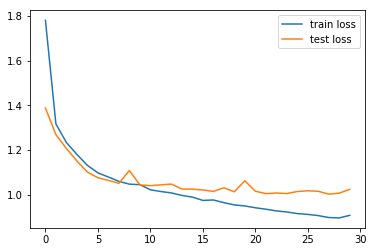

In [38]:
# running epochs for training and validation
HIDDEN_DIM = 128
EPOCHS = 30

model = RNN(WORDEMBSIZE, HIDDEN_DIM, 15)
optimizer = optim.SGD(model.parameters(),lr=0.0005, momentum=0.9)
train_loss = []
test_loss = []
for epoch in range(EPOCHS):
    print("\n\n-------------")
    print("EPOCH: {}".format(epoch + 1))
    running_loss = 0.0
    model.train()
    optimizer.zero_grad()
    print("Training started for epoch:{}".format(epoch + 1))
    X_train, y_train = shuffle(X_train, y_train)
    start_time = time.time()
    correct = total = 0
    minibatch_size = 16
    N = len(y_train)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for idx in range(minibatch_size):
            text = X_train[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_train[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            if loss is None:
                loss = text_loss
            else:
                loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / N)
    print("Training completed for epoch: {}".format(epoch + 1))
    print("Time for train: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))
    
    #validation
    running_loss = 0.0
    model.eval()
    optimizer.zero_grad()
    print("Validation started for epoch:{}".format(epoch + 1))
    X_test, y_test = shuffle(X_test, y_test)
    start_time = time.time()
    correct = total = 0
    minibatch_size = 16
    N = len(y_test)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        for idx in range(minibatch_size):
            text = X_test[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_test[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
    test_loss.append(running_loss / N)
    print("Validation completed for epoch: {}".format(epoch + 1))
    print("Time for validation: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()